In [2]:
import cv2 as cv
import matplotlib.pyplot as plt
import argparse

In [3]:
net = cv.dnn.readNetFromTensorflow("graph_opt.pb") # Tensor Flow Weights model

In [4]:
inWidth = 368
inHeight = 368
thr = 0.2

In [5]:
BODY_PARTS = { "Nose": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
               "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
               "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "REye": 14,
               "LEye": 15, "REar": 16, "LEar": 17, "Background": 18 }

POSE_PAIRS = [ ["Neck", "RShoulder"], ["Neck", "LShoulder"], ["RShoulder", "RElbow"],
               ["RElbow", "RWrist"], ["LShoulder", "LElbow"], ["LElbow", "LWrist"],
               ["Neck", "RHip"], ["RHip", "RKnee"], ["RKnee", "RAnkle"], ["Neck", "LHip"],
               ["LHip", "LKnee"], ["LKnee", "LAnkle"], ["Neck", "Nose"], ["Nose", "REye"],
               ["REye", "REar"], ["Nose", "LEye"], ["LEye", "LEar"] ]

In [6]:
img = cv.imread("Image_6.jpg")

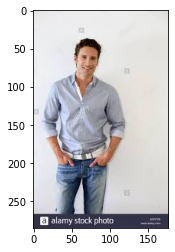

In [7]:
plt.imshow(cv.cvtColor(img,cv.COLOR_BGR2RGB))

In [8]:
def pose_estimation(frame):
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]
    net.setInput(cv.dnn.blobFromImage(frame,1.0, (inWidth, inHeight), (127.5,127.5,127.5), swapRB=True, crop=False))
    out = net.forward()
    out = out[:, :19, :, :]    # For mobile net output
    
    assert(len(BODY_PARTS) == out.shape[1])
    
    points = [] # list of points 
    
    for i in range(len(BODY_PARTS)):
        #Slice heatmaps for corresponding body parts
        heatMap = out[0,i,:,:]
        # Originally, we try to fina all the local maximums. To simplofy a sample we just find a global one.
        # However only a single pose at the same time could be detected this way.
        _, conf, _, point = cv.minMaxLoc(heatMap)
        x = (frameWidth * point[0]) / out.shape[3]
        y = (frameHeight * point[1]) / out.shape[2]
        # Add a point if its confidence is higher than threshold
        points.append((int(x), int(y))if conf > thr else None)
        
    for pair in POSE_PAIRS:
        partForm = pair[0]
        partTo = pair[1]
        assert(partForm in BODY_PARTS)
        assert(partTo in BODY_PARTS)
        
        idForm = BODY_PARTS[partForm]
        idTo = BODY_PARTS[partTo]
        
        if points[idForm] and points[idTo]:
            cv.line(frame, points[idForm], points[idTo], (0, 255 ,0), 3)
            cv.ellipse(frame, points[idForm], (3,3),0,0,360, (0,0,255), cv.FILLED)
            cv.ellipse(frame, points[idTo], (3,3),0,0,360, (0,0,255), cv.FILLED)
    
    t, _ = net.getPerfProfile()
    freq = cv.getTickFrequency() / 1000
    cv.putText(frame, '%.2fms' % (t/freq), (10,20), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0))
    return frame
        

In [9]:
estimatedimg = pose_estimation(img)

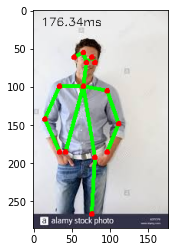

In [10]:
plt.imshow(cv.cvtColor(estimatedimg,cv.COLOR_BGR2RGB))

In [11]:
# Run on Video

In [ ]:
#Portion for any video
#cap = cv.VideoCapture('videoplayback_3.mp4')
#cap.set(cv.CAP_PROP_FPS, 10)

# portion for webcam
cap = cv.VideoCapture(1)
cap.set(cv.CAP_PROP_FPS, 10)


if not cap.isOpened():
    cap = cv.VideoCapture(0)
if not cap.isOpened():
    raise IOError("Can Not Open Video")

while cv.waitKey(1) < 0:
    hasFrame,frame = cap.read()
    if not hasFrame:
        cv.waitKey()
        break
        
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]
    net.setInput(cv.dnn.blobFromImage(frame,1.0, (inWidth, inHeight), (127.5,127.5,127.5), swapRB=True, crop=False))
    out = net.forward()
    out = out[:, :19, :, :]    # For mobile net output
    
    assert(len(BODY_PARTS) == out.shape[1])
    
    points = [] # list of points 
    
    for i in range(len(BODY_PARTS)):
        #Slice heatmaps for corresponding body parts
        heatMap = out[0,i,:,:]
        # Originally, we try to fina all the local maximums. To simplofy a sample we just find a global one.
        # However only a single pose at the same time could be detected this way.
        _, conf, _, point = cv.minMaxLoc(heatMap)
        x = (frameWidth * point[0]) / out.shape[3]
        y = (frameHeight * point[1]) / out.shape[2]
        # Add a point if its confidence is higher than threshold
        points.append((int(x), int(y))if conf > thr else None)
        
    for pair in POSE_PAIRS:
        partForm = pair[0]
        partTo = pair[1]
        assert(partForm in BODY_PARTS)
        assert(partTo in BODY_PARTS)
        
        idForm = BODY_PARTS[partForm]
        idTo = BODY_PARTS[partTo]
        
        if points[idForm] and points[idTo]:
            cv.line(frame, points[idForm], points[idTo], (0, 255 ,0), 3)
            cv.ellipse(frame, points[idForm], (3,3),0,0,360, (0,0,255), cv.FILLED)
            cv.ellipse(frame, points[idTo], (3,3),0,0,360, (0,0,255), cv.FILLED)
    
    t, _ = net.getPerfProfile()
    freq = cv.getTickFrequency() / 1000
    cv.putText(frame, '%.2fms' % (t/freq), (10,20), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0))
    
    cv.imshow("Pose Estimation", frame)